<a href="https://colab.research.google.com/github/Lab-of-Infinity/Text-Classification-using-FineTuned-BERT-Transformer/blob/main/Binary_Text_Classification_using_FineTuned_BERT_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ## **Binary Text Classification using FineTuned BERT Transformer Model**

- **Objective : To perform Text Classification on Movies Review Dataset and Classify Review as Positive or Negative Sentiment.**

- **Dataset : [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) From Stanford**

- **Methodology: Using a pretrained BERT transformers model and fine-tune it on a classification task.**

- **Implementation Framework: PyTorch**

In [ ]:
%cd /content/drive/MyDrive/Binary Text Classification using Fine Tuned Bert Transformer

/content/drive/MyDrive/Binary Text Classification using Fine Tuned Bert Transformer


## Dataset Information

- *For this Text Classification task we are using wellknown **Large Movie Datset from Stanford**.*
- *This is a dataset for binary sentiment classification containing a **set of 25,000 highly polar movie reviews for training, and 25,000 for testing**.*
- *There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided.*




Download the *Large Movie Review Dataset* and unzip it locally.


In [ ]:
# Download the dataset.
!wget -q -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# Unzip the dataset.
!tar -zxf aclImdb_v1.tar.gz

## Installation of Transformer Library

We need to download Transformer Library from HuggingFace

In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


## Importing Require Library & Packages

In [ ]:
import os
import io # python library for different I/O
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed)

In [ ]:
from torch.utils.data import Dataset, DataLoader

Parameter Setting

In [ ]:
# Setting Random Seed value for Reproducibility
set_seed(99)

# Number of Training Epochs
epochs = 3

# length of Batch Size
batch_size = 32

# Max_ length : Pad or truncate text sequences to a specific length
max_length = 60

# GPU utilisation: Will use 'CPU' by default if no GPU found
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformer Model : We will use pretrained Bert-base-uncased model
# In uncased model all text is converted to lower case
model_name = 'bert-base-uncased'

# Label Dicitonary for encoding
labels_ids = {'neg':0, 'pos':1}

# Size of classification Head : Number of target variables or Labels
n_labels = len(labels_ids)

## Implementation of classes & functions required

- **In this section we need to build few helper functions which help us to load dataset and train dataset**
- **Following Functions we are gone implement in `Class MovieReviewsDataset` :**
  - Data Loading using PyTorch DataLoader 
  - Training Pipeline
  - Validation Pipeline

In [ ]:
class MovieReviewsDataset(Dataset):
  """ PyTorch Dataset class for loading data. 
  Here Data Parsing happens & text encoding happens using tokenizer

  Arguments:
    `path` : path to dataset
    `use_tokenizer` : Transformer type tokenizer for text encoding
    `labels_ids` = target variable encoding dictionary
    `max_sequence_len` = maximum desired sequence to truncate or pad text sequences
  """
  def __init__(self, path,use_tokenizer, labels_ids, max_sequence_len = None):
    # Checking path validity 
    if not os.path.isdir(path):
      # Raise error if path is Invalid
      raise ValueError("Invalid 'Path' of Directory : Provide accurate path to data partition") 
    max_sequence_len = use_tokenizer.max_len if max_sequence_len is None else max_sequence_len
    # Creating Empty list for storing texts & label
    texts = []
    labels = []
    print('Reading partitions...')

    # Looping on each label folder data
    for label, label_id in tqdm(labels_ids.items()):
      label_path = os.path.join(path,label)
      # fetching all files path
      files_names = os.listdir(label_path)
      print('Reading %s files...' % label)
      # Loop to read content of each file
      for file_name in tqdm(files_names):
        file_path = os.path.join(label_path, file_name)
        # Read content
        content = io.open(file_path, mode = 'r', encoding='utf-8').read()
        content = fix_text(content) # fixing unicode issue if present
        # appending Content in texts list
        texts.append(content)
        # appending labels for each file
        labels.append(label_id)

    # Number of labels
    self.n_examples = len(labels)
    # tokenization of text
    print("Tokenzation of text is in progress..." )
    self.inputs = use_tokenizer(texts, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt',  max_length=max_sequence_len)
    self.sequence_len = self.inputs['input_ids'].shape[-1]
    print('Text padded or truncated to %d length !' % self.sequence_len)
    self.inputs.update({'labels': torch.tensor(labels)})
    print('Finished! \n')
    return

  def __len__(self):
    """ `len` returns the number of examples/data points
    """
    return self.n_examples
  
  def __getitem__(self, item):
    """ It returns the index of data points.
    """
    return {key: self.inputs[key][item] for key in self.inputs.keys()}
  

In [ ]:
def train(dataloader, optimizer_, scheduler_, device_):
  """ Train pytorch model on single pass through the data loader
  Returns: true_labels, predictions_labels, avg_epoch_loss
  """
  global model 
  # Creating empty list for tracking variables
  predictions_labels = []
  true_labels = []

  # Intialize total loss for this epoch as zero
  total_loss = 0

  # set model under training
  model.train()

  # for each batch of training data
  for batch in tqdm(dataloader, total = len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch  = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Clearing previously calculated gradients
    model.zero_grad()

    # Perform forward pass
    outputs = model(**batch)
    loss, logits = outputs[:2]

    # Accumulate training loss over all batches
    total_loss +=loss.item()  # item function returns python value from tensor

    # Perform backward pass calculation of gradients
    loss.backward()

    # Clip the gradients norm to 1.0 (to prevent explosion gradient problem)
    torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
    optimizer.step()
    # update learning rate
    scheduler.step()

    # moving logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # get predications to list
    predict_content = logits.argmax(axis = -1).flatten().tolist()

    # update list
    predictions_labels += predict_content

  # calculate the average loss over the training data
  avg_epoch_loss = total_loss /  len(dataloader)

  # Return all true labels and predications for future evalutions
  return true_labels, predictions_labels, avg_epoch_loss



In [ ]:
def validation(dataloader,device_):
  """Validation function to evaluate model performance on separate set of data
  """

  global model

  # tracking variable
  predictions_labels = []
  true_labels = []

  # Intialise total loss
  total_loss = 0

  # Putting model in evaluation mode
  model.eval()

  # Evaluate data for one epoch

  for batch in tqdm(dataloader, total = len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # for not storing and computating gradinets
    with torch.no_grad():

      # forward pass, calculate logit predications
      outputs = model(**batch)

      # fetch loss and logit value from return tuple
      loss, logits = outputs[:2]

      # moving logits to cpu memory
      logits = logits.detach().cpu().numpy()

      # Accumlating total loss
      total_loss += loss.item()

      # get predications to list
      predict_content = logits.argmax(axis = -1).flatten().tolist()

      # update predications list
      predictions_labels += predict_content

  # calculate aveage loss over training data
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

# Load Model and Tokenizer

Loding the three esential parts of pretrained transformers: configuration, tokenizer and model. We also need to load model to the device we're planning to use (GPU / CPU).

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name, 
                                          num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)

# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, 
                                                           config=model_config)

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded to `cuda`


# Dataset and DataLoader

Create the PyTorch Dataset and DataLoader objects that will be used to feed data into our model.

In [ ]:
print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = MovieReviewsDataset(path='aclImdb/train', 
                               use_tokenizer=tokenizer, 
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with ...')
# Create pytorch dataset.
valid_dataset =  MovieReviewsDataset(path='aclImdb/test', 
                               use_tokenizer=tokenizer, 
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Reading partitions...


  0%|          | 0/2 [00:00<?, ?it/s]

Reading neg files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Reading pos files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Tokenzation of text is in progress...
Text padded or truncated to 60 length !
Finished! 

Created `train_dataset` with 25000 examples!
Created `train_dataloader` with 782 batches!

Dealing with ...
Reading partitions...


  0%|          | 0/2 [00:00<?, ?it/s]

Reading neg files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Reading pos files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Tokenzation of text is in progress...
Text padded or truncated to 60 length !
Finished! 

Created `valid_dataset` with 25000 examples!
Created `eval_dataloader` with 782 batches!


# Train

Create optimizer and scheduler use by PyTorch in training.

Loop through the number of defined epochs and call the **train** and **validation** functions.


Epoch


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

<ipython-input-11-8852c78462c6>:37: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.13693 - val_loss: 0.46121 - train_acc: 0.95192 - valid_acc: 0.82392


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

<ipython-input-11-8852c78462c6>:37: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.05530 - val_loss: 0.85041 - train_acc: 0.98416 - valid_acc: 0.82632


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

<ipython-input-11-8852c78462c6>:37: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.01888 - val_loss: 1.08609 - train_acc: 0.99536 - valid_acc: 0.82848



/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


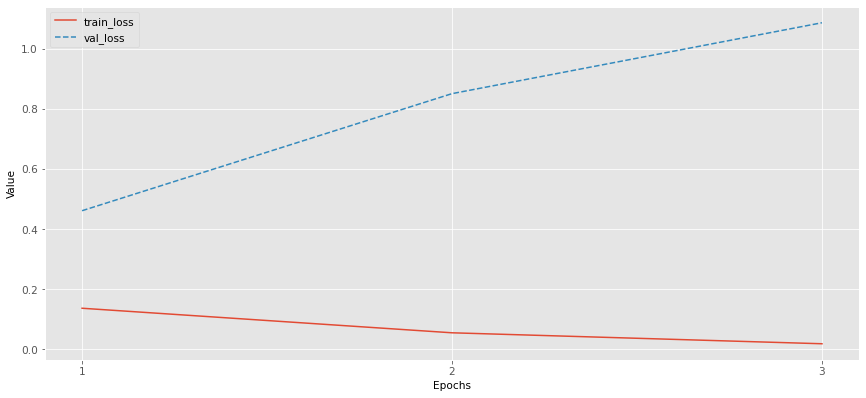

/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


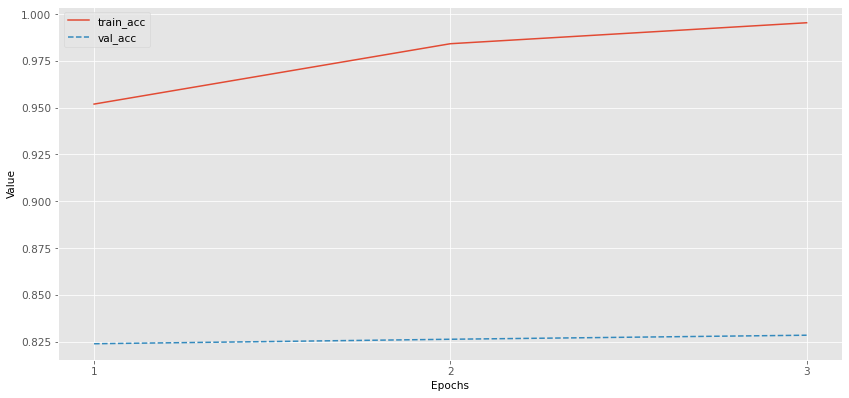

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Evaluate

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

  0%|          | 0/782 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         neg       0.84      0.81      0.83     12500
         pos       0.82      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:676: DeprecationWarning: `magnify` needs to have value in [0,1]! `3` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


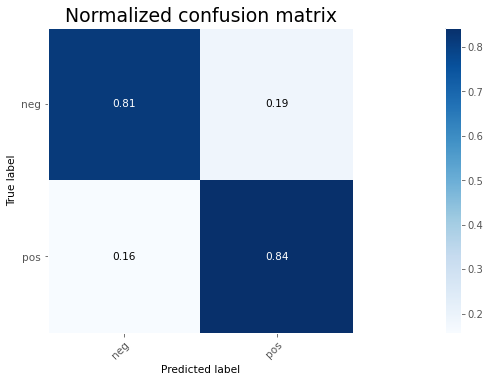

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=3,
                      );